In [ ]:
import pandas as pd
from scipy.stats import skew
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import silhouette_score, davies_bouldin_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# 1️⃣ Đọc dữ liệu
file_path = '/content/drive/MyDrive/data_for_clustering.csv'
df = pd.read_csv(file_path)

# 2️⃣ Chọn feature
numeric_features = [
'item_count', 'cat_count', 'brand_count', 'merchant_count',
    'add-to-cart_count', 'click_count', 'favourite_count', 'purchase_count',
    'sale_click_purchase', 'sale_fav_purchase', 'sale_add_purchase',
    'nosale_click_purchase', 'nosale_fav_purchase', 'nosale_add_purchase',
    'purchase_ratio', 'avg_action_day_ratio', 'avg_active_day',
    'longest_inactivity_days', 'longest_purchase_gap', 'age'
]
categorical_features = ['sex']
X_raw = df[numeric_features + categorical_features].copy()
print(f"Sử dụng {len(numeric_features)} numeric + {len(categorical_features)} categorical features")


Sử dụng 20 numeric + 1 categorical features


In [ ]:
# 3️⃣ Xử lý missing
X_raw['age'].fillna(X_raw['age'].median(), inplace=True)
X_raw['sex'].fillna('Other', inplace=True)
X_raw['sex'] = X_raw['sex'].str.strip().str.capitalize()

print("Giá trị sex duy nhất:", X_raw['sex'].unique())

/tmp/ipython-input-749574399.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_raw['age'].fillna(X_raw['age'].median(), inplace=True)
/tmp/ipython-input-749574399.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

Giá trị sex duy nhất: ['M' 'F' 'Other']


In [ ]:
from scipy.stats import skew
import numpy as np

# Tính skewness
skewness_dict = {feat: skew(X_raw[feat]) for feat in numeric_features}
for feat, sk in skewness_dict.items():
    print(f"{feat}: skewness = {sk:.2f}")

# Log-transform các feature lệch phải >1
skewed_features = [feat for feat, sk in skewness_dict.items() if sk > 1]

for feat in skewed_features:
    X_raw[feat] = np.log1p(X_raw[feat])

item_count: skewness = 6.41
cat_count: skewness = 2.01
brand_count: skewness = 4.06
merchant_count: skewness = 4.21
add-to-cart_count: skewness = 8.08
click_count: skewness = 8.81
favourite_count: skewness = 13.27
purchase_count: skewness = 8.44
sale_click_purchase: skewness = 74.63
sale_fav_purchase: skewness = 8.99
sale_add_purchase: skewness = 15.66
nosale_click_purchase: skewness = 9.88
nosale_fav_purchase: skewness = 15.44
nosale_add_purchase: skewness = 14.94
purchase_ratio: skewness = 2.82
avg_action_day_ratio: skewness = 15.43
avg_active_day: skewness = 2.10
longest_inactivity_days: skewness = 1.07
longest_purchase_gap: skewness = 0.50
age: skewness = 0.85


In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)

X_processed = preprocessor.fit_transform(X_raw)


In [ ]:

pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_processed)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_processed)
# Thêm label vào dataframe để phân tích sau này
df['cluster'] = labels
print(df['cluster'].value_counts())

cluster
2    230430
1    175504
0     18236
Name: count, dtype: int64


In [ ]:
# Trung bình các đặc trưng số
cluster_mean = df.groupby('cluster')[numeric_features].mean().round(2)

# Đặc trưng phân loại (như sex)
cluster_cat = df.groupby('cluster')[categorical_features].agg(lambda x: x.value_counts().index[0])

# % giới tính theo cụm
sex_dist = pd.crosstab(df['cluster'], df['sex'], normalize='index') * 100
sex_dist = sex_dist.round(1).add_suffix('_%')

# Gộp tất cả
cluster_profile = cluster_mean.join(cluster_cat).join(sex_dist)

cluster_profile

,item_count,cat_count,brand_count,merchant_count,add-to-cart_count,click_count,favourite_count,purchase_count,sale_click_purchase,sale_fav_purchase,...,purchase_ratio,avg_action_day_ratio,avg_active_day,longest_inactivity_days,longest_purchase_gap,age,sex,F_%,M_%,other_%
cluster,,,,,,,,,,,,,,,,,,,,,
0,59.31,18.88,26.97,27.56,3.37,90.43,3.22,5.40,7.84,0.14,...,0.42,8.24,2.76,53.85,51.57,30.05,F,62.2,34.0,3.8
1,140.38,36.15,56.56,57.25,0.05,216.32,14.67,11.71,10.73,0.45,...,0.61,9.02,4.46,36.77,64.70,30.95,F,75.9,21.7,2.4
2,26.83,12.40,15.15,15.23,0.03,38.79,1.62,4.94,4.32,0.08,...,0.37,5.74,2.10,61.83,57.52,29.83,F,62.8,35.3,1.9


In [ ]:
# Gắn nhãn theo yêu cầu của bạn
cluster_labels = {
    0: "Deal Hunter",
    1: "Khách hàng lâu dài",
    2: "Khách hàng tiềm năng"
}

# Áp dụng vào dataframe
df['cluster_name'] = df['cluster'].map(cluster_labels)

# Xem kết quả
print(df['cluster_name'].value_counts().sort_index())

cluster_name
Deal Hunter              18236
Khách hàng lâu dài      175504
Khách hàng tiềm năng    230430
Name: count, dtype: int64


In [ ]:
cluster_summary = df.groupby('cluster')[numeric_features].mean()
cluster_summary_cat = df.groupby('cluster')[categorical_features].agg(lambda x: x.value_counts().index[0])
users_by_cluster = df.groupby('cluster')['user_id'].apply(list)
print(users_by_cluster)
df[['user_id', 'cluster']].to_csv("users_with_clusters.csv", index=False)


cluster
0    [18, 23, 47, 69, 73, 86, 95, 99, 104, 117, 125...
1    [5, 6, 8, 14, 15, 19, 20, 21, 22, 25, 28, 32, ...
2    [1, 2, 3, 4, 7, 9, 10, 11, 12, 13, 16, 17, 24,...
Name: user_id, dtype: object


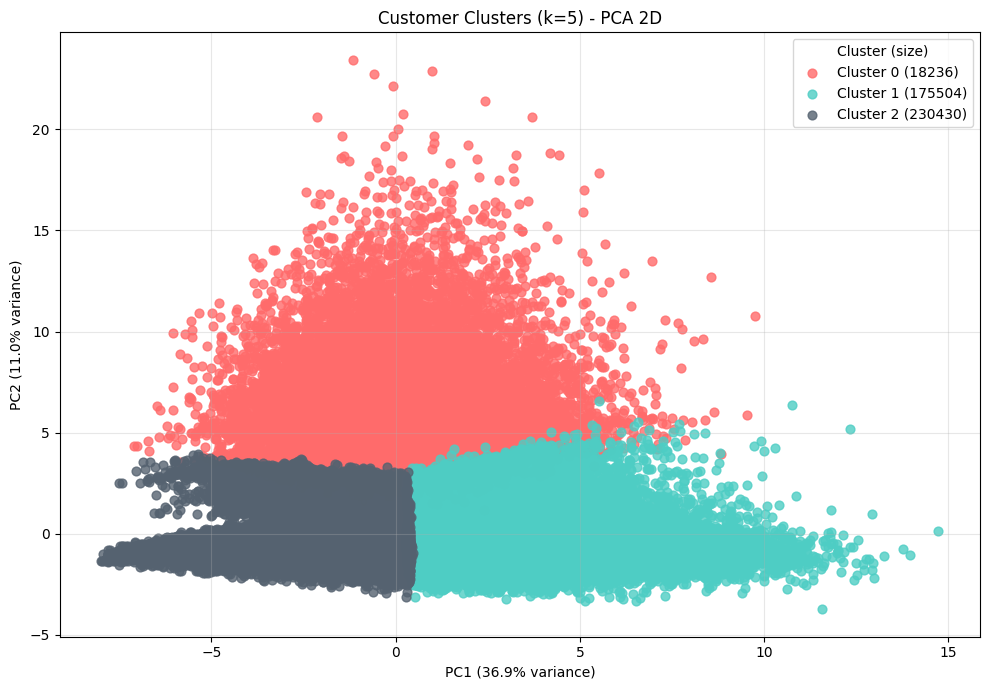

In [ ]:

# PCA 2D
pca = PCA(n_components=2, random_state=42)
X_pca_2d = pca.fit_transform(X_processed)

# Lấy nhãn từ mô hình KMeans 3 cụm (clusters đã gắn vào df trước đó)
labels = df['cluster'].values

# Chọn 3 màu rõ ràng, dễ phân biệt
colors = ['#FF6B6B', '#4ECDC4', '#556270',]

plt.figure(figsize=(10,7))
for cluster_id, color in zip(sorted(np.unique(labels)), colors):
    mask = labels == cluster_id
    plt.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1],
                s=40, color=color, alpha=0.8, label=f'Cluster {cluster_id} ({mask.sum()})')

# Nhãn trục và tiêu đề
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('Customer Clusters (k=5) - PCA 2D')
plt.grid(True, alpha=0.3)
plt.legend(title='Cluster (size)')
plt.tight_layout()
plt.show()



/tmp/ipython-input-2114221809.py:25: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


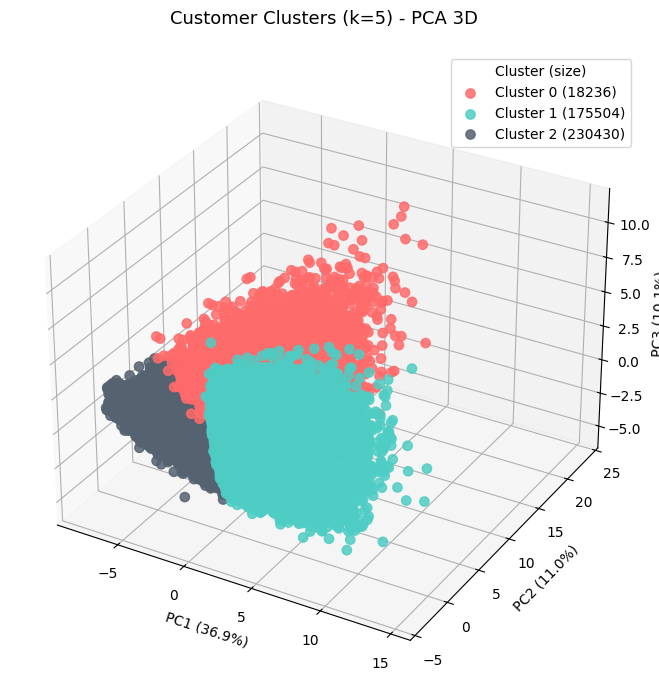

In [ ]:
# PCA 3D
pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_processed)

# Màu cho 5 cụm
colors = ['#FF6B6B', '#4ECDC4', '#556270',]

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

for cluster_id, color in zip(sorted(np.unique(labels)), colors):
    mask = labels == cluster_id
    ax.scatter(X_pca_3d[mask, 0], X_pca_3d[mask, 1], X_pca_3d[mask, 2],
               s=45, color=color, alpha=0.85, label=f'Cluster {cluster_id} ({mask.sum()})')

# Gắn nhãn trục
ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})')
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})')

# Tiêu đề và legend
ax.set_title('Customer Clusters (k=5) - PCA 3D', fontsize=13, pad=20)
ax.legend(title='Cluster (size)')
# Cho phép xoay và zoom chuột trong Colab
plt.tight_layout()
plt.show()




In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

sil_score = silhouette_score(X_processed, labels)
db_score = davies_bouldin_score(X_processed, labels)
inertia = kmeans.inertia_
print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies–Bouldin Index: {db_score:.3f}")
print(f"Inertia (WSS): {inertia:.0f}")

Silhouette Score: 0.233
Davies–Bouldin Index: 1.482
Inertia (WSS): 5879004
